In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append("..")

In [3]:
# Python
from pathlib import Path
import os
import warnings
import math
import datetime
import time
warnings.filterwarnings('ignore')

# Extern
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision
from torchvision.models.resnet import resnet18
from dotted_dict import DottedDict
import pickle
from tqdm import tqdm
import pprint
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

# Local
from BTwins.barlow import *
from BTwins.transform_utils import *
from csprites.datasets import ClassificationDataset
import utils
from backbone import get_backbone
from optimizer import get_optimizer

# Notes
- Without geometric stuff transform!

# Paper Stuff
### Lrearning Rates
Batch Size	Learning Rate
- 128  0.7
- 256  0.4
- 512  0.3
- 1024 0.25
- 2048 0.2
- 4096 0.2

In [4]:
def calc_lambda(d):
    return 1/((d-1) * 0.0244)
for d in [128, 256, 512, 1024, 2048, 4096, 8192]:
    print("{:4}: {:.4f}".format(d, calc_lambda(d)))

 128: 0.3227
 256: 0.1607
 512: 0.0802
1024: 0.0401
2048: 0.0200
4096: 0.0100
8192: 0.0050


In [5]:
config = {
    'device': 'cuda',
    'cuda_visible_devices': '1',
    #'p_data': "/mnt/data/csprites/single_csprites_64x64_n7_c16_a16_p8_s4_bg_inf_random_function_458752",
    #'p_data': "/mnt/data/csprites/single_csprites_32x32_n7_c32_a32_p6_s2_bg_inf_random_function_100000",
    'p_data': '/mnt/data/csprites-models/single_csprites_64x64_n7_c512_a32_p10_s3_bg_inf_random_function_100000',
    'target_variable': 'shape',
    'batch_size': 512,
    'num_workers': 6,
    'num_epochs': 100,
    'freqs': {
        'ckpt': 50,         # epochs
        'linprob': 5,       # epochs
    },
    'num_vis': 64,
    'backbone': "ResNet-18",
    'optimizer': 'adam',
    'optimizer_args': {
        'lr': 0.001,
        'weight_decay': 1e-6
    },
    'projector': [1024, 1024, 1024],
    'scale_factor': 1,
    'p_ckpts': "ckpts",
    'p_model': "model_{}.ckpt",
    'p_stats': "stats.pkl",
    'p_config': 'config.pkl',
    'p_R_train': 'R_train.npy',
    'p_R_valid': 'R_valid.npy',
    'p_Y_valid': 'Y_valid.npy',
    'p_Y_train': 'Y_train.npy',
    'linprob': {
        'optimizer': 'adam',
        'optimizer_args': {
            'lr': 0.001,
            'weight_decay': 1e-6
        },
        'n_hid': 0,
        'd_hid': 1024,
        'num_epochs': 1
    }
    
}
p_base = Path("/mnt/experiments/csprites") / Path(config["p_data"]).name
#
ts = time.time()
st = datetime.datetime.fromtimestamp(ts).strftime('%Y-%m-%d_%H-%M-%S')
#
config["p_experiment"] = str(p_base / "BTwins_bb_[{}]_target_[{}]_{}".format(config["backbone"],
                                                           config["target_variable"],
                                                                            st))
config['lambd'] = calc_lambda(config["projector"][-1])
config = DottedDict(config)
pprint.pprint(config)

{'backbone': 'ResNet-18',
 'batch_size': 512,
 'cuda_visible_devices': '1',
 'device': 'cuda',
 'freqs': DottedDict({'ckpt': 50, 'linprob': 5}),
 'lambd': 0.040062176497924776,
 'linprob': {'d_hid': 1024,
             'n_hid': 0,
             'num_epochs': 1,
             'optimizer': 'adam',
             'optimizer_args': {'lr': 0.001,
                                'weight_decay': 1e-06}},
 'num_epochs': 100,
 'num_vis': 64,
 'num_workers': 6,
 'optimizer': 'adam',
 'optimizer_args': DottedDict({'lr': 0.001, 'weight_decay': 1e-06}),
 'p_R_train': 'R_train.npy',
 'p_R_valid': 'R_valid.npy',
 'p_Y_train': 'Y_train.npy',
 'p_Y_valid': 'Y_valid.npy',
 'p_ckpts': 'ckpts',
 'p_config': 'config.pkl',
 'p_data': '/mnt/data/csprites-models/single_csprites_64x64_n7_c512_a32_p10_s3_bg_inf_random_function_100000',
 'p_experiment': '/mnt/experiments/csprites/single_csprites_64x64_n7_c512_a32_p10_s3_bg_inf_random_function_100000/BTwins_bb_[ResNet-18]_target_[shape]_2021-08-19_09-26-22',
 'p_model

In [6]:
# TORCH SETTINGS
torch.backends.cudnn.benchmark = True
os.environ["CUDA_VISIBLE_DEVICES"] = config.cuda_visible_devices
device = torch.device(config.device)

# Colors

# Dataset

In [7]:
p_ds_config = Path(config.p_data) / "config.pkl"

with open(p_ds_config, "rb") as file:
    ds_config = pickle.load(file)

target_variable = config.target_variable
target_idx = [idx for idx, target in enumerate(ds_config["classes"]) if target == target_variable][0]
n_classes = ds_config["n_classes"][target_variable]

In [8]:
norm_transform = utils.normalize_transform(
    ds_config["means"],
    ds_config["stds"])
inverse_norm_transform = utils.inverse_normalize_transform(
    ds_config["means"],
    ds_config["stds"]
)
target_transform = lambda x: x[target_idx]

transform_train = transforms.Compose([
                #transforms.Resize(ds_config["img_size"]),
                transforms.RandomResizedCrop(ds_config["img_size"],
                                             scale=(0.8, 1.0),
                                            interpolation=Image.BICUBIC),
                transforms.RandomHorizontalFlip(p=0.5),
                transforms.RandomApply(
                    [transforms.ColorJitter(brightness=0.4, contrast=0.4,
                                            saturation=0.2, hue=0.1)],
                    p=0.8
                ),
                transforms.RandomGrayscale(p=0.2),
                GaussianBlur(p=1.0),
                Solarization(p=0.0),
                transforms.ToTensor(),
                norm_transform
            ])

transform_train_prime = transforms.Compose([
                #transforms.Resize(ds_config["img_size"]),
                transforms.RandomResizedCrop(ds_config["img_size"],
                                             scale=(0.8, 1.0),
                                            interpolation=Image.BICUBIC),
                transforms.RandomHorizontalFlip(p=0.5),
                transforms.RandomApply(
                    [transforms.ColorJitter(brightness=0.4, contrast=0.4,
                                            saturation=0.2, hue=0.1)],
                    p=0.8
                ),
                transforms.RandomGrayscale(p=0.2),
                GaussianBlur(p=0.1),
                Solarization(p=0.2),
                transforms.ToTensor(),
                norm_transform
            ])

transform_linprob = transforms.Compose([
                transforms.Resize(ds_config["img_size"]),
                transforms.ToTensor(),
                norm_transform
            ])

In [9]:
ds = ClassificationDataset(
    p_data = config.p_data,
    transform=None,
    target_transform=None,
    split="train"
)

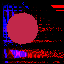

In [13]:
x,y = ds[20]
x

In [130]:
t1 = transforms.Compose([
                #transforms.Resize(ds_config["img_size"]),
                transforms.RandomResizedCrop(ds_config["img_size"],
                                             scale=(0.4, 1.0),
                                             ratio=(1, 1),   # keep aspect ratio!
                                            interpolation=Image.BICUBIC),
                transforms.RandomHorizontalFlip(p=0.5),
])

t2 = transforms.Compose([
                transforms.RandomApply(
                    [transforms.ColorJitter(brightness=0.4, contrast=0.4,
                                            saturation=0.2, hue=0.1)],
                    p=0.8
                ),
                transforms.RandomGrayscale(p=0.2),
                GaussianBlur(p=1.0),
                Solarization(p=0.0),
                #transforms.ToTensor()
])

In [133]:
x1 = t2(x)
x2 = t2(x)
x11 = t1(x1)
x12 = t1(x1)
x21 = t1(x2)
x22 = t1(x2)
#
x12 = np.array(x12)
x11 = np.array(x11)
x21 = np.array(x21)
x22 = np.array(x22)

xx = [x11, x12, x21, x22]

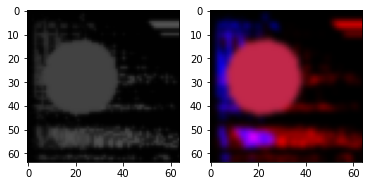

In [135]:
xx = [x1, x2]
n_cols = len(xx)
n_rows = 1
scale_factor = 3

fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * scale_factor, scale_factor))
#
for idx in range(n_cols):
    axes[idx].imshow(xx[idx])
plt.show()

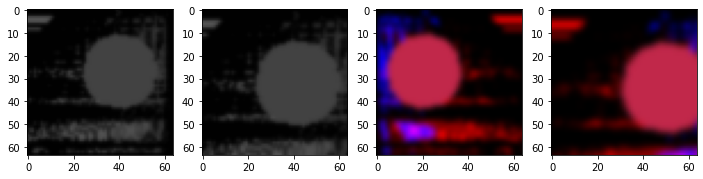

In [136]:
xx = [x11, x12, x21, x22]
n_cols = len(xx)
n_rows = 1
scale_factor = 3

fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * scale_factor, scale_factor))
#
for idx in range(n_cols):
    axes[idx].imshow(xx[idx])
plt.show()

# OLD

In [ ]:
# TRAIN
ds_train = ClassificationDataset(
    p_data = config.p_data,
    transform=Transform(transform_train, transform_train_prime),
    target_transform=target_transform,
    split="train"
)
dl_train = DataLoader(
    ds_train,
    batch_size=config.batch_size,
    shuffle=True,
    num_workers=config.num_workers,
    pin_memory=False,
    drop_last=True
)
# LINPROB
ds_linprob = ClassificationDataset(
    p_data = config.p_data,
    transform=transform_linprob,
    target_transform=target_transform,
    split="valid"
)
dl_linprob = DataLoader(
    ds_linprob,
    batch_size=config.batch_size,
    shuffle=True,
    num_workers = config.num_workers,
    pin_memory=False
)

# Visualize Data

In [ ]:
n_vis = config.num_vis

In [ ]:
# dl_train
(x1, x2),_ = next(iter(dl_train))
x1 = x1[:n_vis]
x2 = x2[:n_vis]
#
x1 = inverse_norm_transform(x1)
x2 = inverse_norm_transform(x2)
#
grid_img = torchvision.utils.make_grid(x1, nrow=int(np.sqrt(n_vis)))
plt.imshow(grid_img.permute(1, 2, 0))
plt.show()

grid_img = torchvision.utils.make_grid(x2, nrow=int(np.sqrt(n_vis)))
plt.imshow(grid_img.permute(1, 2, 0))
plt.show()

(x1 - x2).sum()

In [ ]:
# dl_linprob_train
x,y = next(iter(dl_linprob))
x = x[:n_vis]
y = y[:n_vis]
#
x = inverse_norm_transform(x)
#
grid_img = torchvision.utils.make_grid(x, nrow=int(np.sqrt(n_vis)))
plt.imshow(grid_img.permute(1, 2, 0))
#
y = [ds_config["class_maps"]["shape"][idx.item()] for idx in y]
print(y)

# Model

In [ ]:
model = BarlowTwins(get_backbone(config.backbone, pretrained=False, zero_init_residual=True),
                    config.projector,
                    config.lambd,
                    config.scale_factor)
#
if torch.cuda.device_count() > 1 and device != "cpu":
    print("Using {} gpus!".format(torch.cuda.device_count()))
    model = torch.nn.DataParallel(model)
    model.backbone = model.module.backbone
elif device != "cpu":
    print("Using 1 GPU!")
else:
    print("Using CPU!")
model = model.to(device)

In [ ]:
model

In [ ]:
optimizer = get_optimizer(config.optimizer, model.parameters(), config.optimizer_args)

In [ ]:
stats = {
    'train': {
        'loss': [],
        'epoch': [],
    },
    'linprob': {
        'linacc': [],
        'knnacc': [],
        'epoch': [],
    }
}
stats = DottedDict(stats)
#
p_experiment = Path(config.p_experiment)
p_experiment.mkdir(exist_ok=True, parents=True)
p_ckpts = p_experiment / config.p_ckpts
p_ckpts.mkdir(exist_ok=True)

In [ ]:
config.p_experiment

In [ ]:
global_step = 0
for epoch_idx in range(1, config.num_epochs + 1, 1):
    ################
    # TRAIN
    ################
    model.train()
    epoch_step = 0
    epoch_loss = 0
   
    desc = "Epoch [{:3}/{:3}] {}:".format(epoch_idx, config.num_epochs, 'train')
    pbar = tqdm(dl_train, bar_format= desc + '{bar:10}{r_bar}{bar:-10b}')
    #
    for (x1, x2), _ in pbar:
        x1 = x1.to(device)
        x2 = x2.to(device)
        for param in model.parameters():
            param.grad = None
        loss = model(x1, x2)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        epoch_step += 1
        global_step += 1
        #
        pbar.set_postfix({'loss': loss.item()})

    stats.train.loss.append(epoch_loss / epoch_step)
    stats.train.epoch.append(epoch_idx)

    ################
    # Linprob
    ################
    if epoch_idx % config.freqs.linprob == 0 or epoch_idx == config.num_epochs:
        model.eval()
        R = []
        Y = []
        with torch.no_grad():
            for x, y in dl_linprob:
                x = x.to(device)
                r = model.backbone(x)
                R.append(r.detach().cpu().numpy())
                Y.append(y.cpu().numpy())
        R = np.concatenate(R)
        Y = np.concatenate(Y)
        #
        knn = KNeighborsClassifier(n_neighbors=5)
        knn.fit(R, Y)
        knnacc = knn.score(R, Y)
        #
        clf = LogisticRegression(random_state=0, tol=0.001, max_iter=200).fit(R, Y)
        linacc = clf.score(R, Y)
        print("    Linprob Eval @LR: {:.2f} @KNN: {:.2f}".format(linacc, knnacc))
        stats.linprob.epoch.append(epoch_idx)
        stats.linprob.knnacc.append(knnacc)
        stats.linprob.linacc.append(linacc)
        model.train()
    # Checkpoint
    if epoch_idx % config.freqs.ckpt == 0 or epoch_idx == config.num_epochs:
        print("save model!")
        if torch.cuda.device_count() > 1 and device != "cpu":
            torch.save(model.module.state_dict(), p_ckpts / config.p_model.format(epoch_idx))
        else:
            torch.save(model.state_dict(), p_ckpts / config.p_model.format(epoch_idx))

In [ ]:
x1 = x1[:n_vis]
x2 = x2[:n_vis]
#
x1 = x1.cpu()
x2 = x2.cpu()

In [ ]:
x1 = inverse_norm_transform(x1)
x2 = inverse_norm_transform(x2)
#
grid_img = torchvision.utils.make_grid(x1, nrow=int(np.sqrt(n_vis)))
plt.imshow(grid_img.permute(1, 2, 0))
plt.show()

grid_img = torchvision.utils.make_grid(x2, nrow=int(np.sqrt(n_vis)))
plt.imshow(grid_img.permute(1, 2, 0))
plt.show()

(x1 - x2).sum()

# Plot 

In [ ]:
# plot losses
plt.plot(stats.train.epoch, stats.train.loss, label="train")
plt.legend()
plt.savefig(p_experiment / "barlow_loss.png")
plt.show()


# plot linprob loss
#plt.plot(stats.linprob.epoch, stats.linprob.loss, label="train")
#plt.legend()
#plt.savefig(p_experiment / "linprob_loss.png")
#plt.show()

# plot linprob acc
plt.plot(stats.linprob.epoch, stats.linprob.knnacc, label="knn")
plt.plot(stats.linprob.epoch, stats.linprob.linacc, label="lin")
plt.yscale("log")
plt.legend()
plt.savefig(p_experiment / "linprob_acc.png")
plt.show()

# Save stats and config

In [ ]:
with open(p_experiment / config.p_config, "wb") as file:
    pickle.dump(config, file)
with open(p_experiment / config.p_stats, "wb") as file:
    pickle.dump(stats, file)

# Get Representations 

In [ ]:
p_R_train = p_experiment / config["p_R_train"]
p_Y_train = p_experiment / config["p_Y_train"]
p_R_valid = p_experiment / config["p_R_valid"]
p_Y_valid = p_experiment / config["p_Y_valid"]

In [ ]:
# TRAIN
ds_train = ClassificationDataset(
    p_data = config.p_data,
    transform=transform_linprob,
    target_transform=None,
    split="train"
)
dl_train = DataLoader(
    ds_train,
    batch_size=config.batch_size,
    shuffle=False,
    num_workers=config.num_workers,
    pin_memory=False,
    drop_last=True
)
# LINPROB
ds_valid = ClassificationDataset(
    p_data = config.p_data,
    transform=transform_linprob,
    target_transform=None,
    split="valid"
)
dl_valid = DataLoader(
    ds_valid,
    batch_size=config.batch_size,
    shuffle=False,
    num_workers = config.num_workers,
    pin_memory=False
)

In [ ]:
R_train = []
R_valid = []
Y_train = []
Y_valid = []
#
model.eval()
for x, y in tqdm(dl_train):
    x = x.to(device)
    with torch.no_grad():
        r = model.backbone(x).detach().cpu().numpy()
    R_train.append(r)
    Y_train.append(y.numpy())
#
for x, y in tqdm(dl_valid):
    x = x.to(device)
    with torch.no_grad():
        r = model.backbone(x).detach().cpu().numpy()
    R_valid.append(r)
    Y_valid.append(y.numpy())

R_train = np.concatenate(R_train)
R_valid = np.concatenate(R_valid)
Y_train = np.concatenate(Y_train)
Y_valid = np.concatenate(Y_valid)

In [ ]:
np.save(p_R_train, R_train)
np.save(p_Y_train, Y_train)
np.save(p_R_valid, R_valid)
np.save(p_Y_valid, Y_valid)

In [ ]:
p_R_train

In [ ]:
Y_train.shape

In [ ]:
Y_valid.shape